# Intelligent Systems in Medical Imaging 2023

This Jupyter notebook is part of the course Intelligent Systems in Medical Imaging (ISMI) from Radboud University (Nijmegen, Netherlands), and it was developed by researchers of Radboud University Medical Center (Nijmegen, Netherlands).

You should have obtained this notebook by downloading it from the official Brightspace page of the course.

This notebook formulates an assignment as part of the ISMI course, and the content of this notebook should be used solely to develop a solution to this assignment. You should not make the code provided in this notebook, or your own solution, publicly available.

## Teaching Assistants

* Bram de Wilde (bram.dewilde@radboudumc.nl)
* Pierpaolo Vendittelli (pierpaolo.vendittelli@radboudumc.nl)
* Joeran Bosma (joeran.bosma@radboudumc.nl)
* Stephan Dooper (stephan.dooper@radboudumc.nl)

For questions about the assignments that go beyond the content, you can contact Bram de Wilde. Questions about the content are addressed in the tutorial sessions. You are also encouraged to use the Brightspace discussion forums to discuss content of the assignments. We will also keep an eye out there to help!

## Guidelines and instructions
Make sure you write code in any place that says "YOUR CODE HERE" by substituting `None` variables or by adding your own solution. Make sure you write in any place that says "YOUR ANSWER HERE" with your answers to the questions.

Please **do not delete or add any cells**.

Before you turn this problem in, make sure everything runs without errors. The easiest way to check this is to restart the kernel and run all cells (in the menubar, select Runtime$\rightarrow$Restart & Run All).

* Groups: You should work in **groups of 2 or 3 people**. (groups of 2 are preferred!)
* You are expected to work in Google Colab. If you run the notebooks locally, you may have to solve some issues yourself!
* Submit your **fully executed** notebook to Brightspace with file name format: `GroupN_NameSurname1_NameSurname2_NameSurname3.ipynb`
* The deadlines for all assignments are on Brightspace.
* Deadlines are soft, but make an effort to be on time. We prioritise feedback on assignments that are handed in before the deadline.
* Each assignment has 100 points, your grade is your total number of points divided by 10.
* The assignments are mandatory, but **do not count** towards your final grade for the course.
* For assignments where you have to submit to grand-challenge.org, use team name format `ismi-GroupN-nickname1`.
* When working with Google Colab, we advise you to download model checkpoints (.h5 files). This way you don't lose your checkpoint if your session times out. Also, don't forget to connect to a **GPU runtime** when training neural networks!
* In Google Colab, you can mount your Google Drive to save files, by clicking the Folder icon on the left, and then click the Mount Drive icon.

There are more detailed instructions on Brightspace on how to use Google Colab for the assignments. You can find it here: https://brightspace.ru.nl/d2l/le/content/333312/Home

## Students
Please fill in this cell with your names, e-mail address and s-numbers. This information will be used to grade your assignment.

* [Ivan Slootweg], [s1001424], [ilse.slootweg@ru.nl]
* [Elina Antonova], [s1057069], [elina.antonova@ru.nl]
* [Sven van der Post], [s1028679], [sven.vanderpost@ru.nl]

# Introduction to CAD systems and image processing basic
In this first assignment, you will implement and apply some basic image processing techniques, while getting familiar with a few types of medical imaging data.
In particular, you will be working with data from:
* mammography (breast, 2D)
* histopathology (colon, 2D)
* chest CT (lungs, 3D)

You will implement the following techniques:
1. conversion of raw mammography data into a gray-scale image
2. stain normalization in digital pathology with histogram matching
3. trachea detection in chest CT with blob detection

First, import the libraries necessary for this assignment.

In [18]:
%pip install -q --upgrade ismi_utils

In [19]:
import copy

import matplotlib.pyplot as plt
import numpy as np
import scipy.signal
import SimpleITK as sitk
from matplotlib import cm
from scipy.ndimage import binary_fill_holes

from ismi_utils import download_data

## Data
All data used in this assignment, as well as in all assignments of this course, are publicly available, and mostly data are stored in a public folder on SURFDrive.
The data for this assignment can be downloaded by executing the next cell.
This will download and uncompress data contained in the file ```assignment_1.zip``` to a folder ```/your_notebook_directory/assignment_1```.

Run the next cell and wait until the progress bar becomes green.
On a decent network connection it should take ~1 minute.

In [20]:
download_data("assignment_1.zip", link="https://surfdrive.surf.nl/files/index.php/s/5675CTqWNfms8GS/download")

100%|██████████| 178M/178M [00:05<00:00, 31.4MB/s]


Check that the downloaded folder contains the following structure:
````
assignment_1
  |-LIDC-IDRI
    |-LIDC-IDRI-0001
      |-1.3.6.1.4.1.14519.5.2.1.6279.6001.298806137288633453246975630178
        |-1.3.6.1.4.1.14519.5.2.1.6279.6001.179049373636438705059720603192
          |-000001.dcm
          |-...
  |-CRC-Prim-HE-05_APPLICATION.mha
  |-CRC-Prim-HE-10_APPLICATION.mha
  |-processed_mammography.mhd
  |-processed_mammography.raw
  |-raw_mammography.mhd
  |-raw_mammography.raw
````

## 1. Gray-scale transformation of breast tomography (55 points)
The first assignment consists of reconstructing a gray-scale mammography image from the raw data acquired with the mammography machine. As you have seen in the lecture, there are several steps that have to be applied to reconstruct a gray-scale image, which can be interpreted by radiologists to detect tumors, masses, cysts and micro-calcifications.

### Read image
In your local data folder, you can find a file containing raw mammography data and the corresponding processed gray-level version. The processed version comes from the vendor and is the result of several filtering and enhancement steps that are proprietary. Your goal is to do a good job at deriving a gray-level image from raw data.
The files are in ITK format, with extension ````.mhd````, and can be opened using the library ````SimpleITK````. You can find documentation on ````SimpleITK```` at this link: http://www.simpleitk.org/SimpleITK/help/documentation.html.
In the next cell, we provide the function used to read the raw data and the gray-level images.
Furthermore, we indicate which steps have to be implemented.
Complete the assignment by implementing the steps indicated.

In [21]:
# Raw and gray-level data in ITK format
raw_img_filename = "./assignment_1/raw_mammography.mhd"
out_img_filename = "./assignment_1/processed_mammography.mhd"

# Read ITK files using SimpleITK
raw_img = sitk.ReadImage(raw_img_filename)
out_img = sitk.ReadImage(out_img_filename)

# Print image information
print(f"image size: {raw_img.GetSize()}")
print(f"image origin: {raw_img.GetOrigin()}")
print(f"image spacing: {raw_img.GetSpacing()}")
print(f"image width: {raw_img.GetWidth()}")
print(f"image height: {raw_img.GetHeight()}")
print(f"image depth: {raw_img.GetDepth()}")

image size: (2560, 3328)
image origin: (0.0, 0.0)
image spacing: (0.07000000029802322, 0.07000000029802322)
image width: 2560
image height: 3328
image depth: 0


**Question:**
What is the width of the image in mm? 

*Hint: the image adheres to the DICOM standard for pixel spacing*

width = spacing * array width = 179.2 mm

### Convert ITK image to Numpy array
In order to easily manipulate data, it is convenient to convert it to a numpy array. Numpy arrays can be transformed using the `numpy` library and can easily be visualized using the `matplotlib` library.
Please check the documentation in http://insightsoftwareconsortium.github.io/SimpleITK-Notebooks/Python_html/01_Image_Basics.html to find the proper function to transform the SimpleITK image to numpy. Write your code below:
* ````out_np````: should contain the numpy array from ````out_img````
* ````raw_np````: should contain the numpy array from ````raw_img````

Note: If you are not familiar with Numpy, you can check out this tutorial: http://cs231n.github.io/python-numpy-tutorial/

In [22]:
# Convert the ITK image into numpy format
out_np = None
raw_np = None
# YOUR CODE HERE
out_np = sitk.GetArrayViewFromImage(out_img)
raw_np = sitk.GetArrayViewFromImage(raw_img)

In [23]:
"""DO NOT MODIFY THIS CELL"""
assert(out_np is not None),"out_np cannot be None"
assert(raw_np is not None),"raw_np cannot be None"

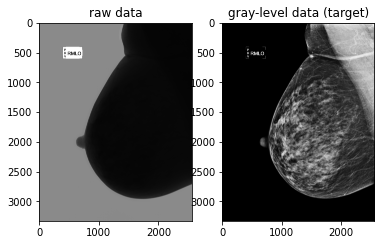

In [24]:
# Visualize the two numpy arrays
plt.subplot(1,2,1)
plt.imshow(raw_np, cmap="gray")
plt.title("raw data")
plt.subplot(1,2,2)
plt.imshow(out_np, cmap="gray")
plt.title("gray-level data (target)")
plt.show()

### Image processing
Implement the three main steps necessary to convert raw data into a gray-level image:
1. Logaritmic transformation
2. Intensity inversion
3. Contrast stretching

<img src="https://github.com/ivanslootweg/ISMI/blob/main/assignment_1/images/raw2gray.png?raw=1">

#### Logaritmic transformation

Implement the logarithmic transformation in the code cell below. You need to implement this function from scratch, so you cannot use the built-in `np.log` function. To prevent math errors, transform the input from `x -> x + 1`. The function should work for any input number or numpy array with positive values.

In [25]:
# Logarithmic transformation
def log_transform(x):
    """Apply a logarithmic transformation"""
    # YOUR CODE HERE
    new_x = np.add(1,x)
    return np.log(new_x)

In [26]:
"""DO NOT MODIFY THIS CELL"""

'DO NOT MODIFY THIS CELL'

Apply the logarithmic transformation to the raw mammography image. The result should be a numpy array with variable name `mammo_log`.

In [27]:
mammo_log = None
# YOUR CODE HERE


mammo_log = log_transform(raw_np)

In [28]:
"""DO NOT MODIFY THIS CELL"""
assert(mammo_log is not None),"mammo_log cannot be None"

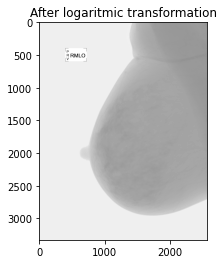

In [29]:
# Visualize the result
plt.imshow(mammo_log, cmap="gray")
plt.title("After logaritmic transformation")
plt.show()

#### Intensity inversion
Implement intensity inversion in the code cell below. You may use any numpy function you like. The function should work for any input number or numpy array, with positive and/or negative numbers.

In [30]:
# Intensity inversion
def intensity_inversion(x):
    """Apply an intensity inversion
    """
    # YOUR CODE HERE
    return np.max(x) - x

In [31]:
"""DO NOT MODIFY THIS CELL"""

'DO NOT MODIFY THIS CELL'

Apply intensity inversion to `mammo_log`. The result should be a numpy array with variable name `mammo_inv`.

In [32]:
# Call the intensity inversion function passing the correct parameter(s)
mammo_inv = None
# YOUR CODE HERE
mammo_inv = intensity_inversion(mammo_log)

In [33]:
"""DO NOT MODIFY THIS CELL"""
assert(mammo_inv is not None),"mammo_inv cannot be None"

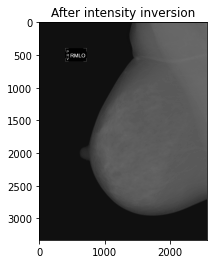

In [34]:
# Visualize the result
plt.imshow(mammo_inv, cmap="gray")
plt.title("After intensity inversion")
plt.show()

#### Contrast stretching
In order to apply the contrast stretching operation, let's first define a general contrast stretching function. The inputs should be at least:

1. the input signal, 
2. the window range values ```p0``` and ```pk```, as defined in the lecture.


**Note**: The end results should not contain intensity values larger than ```qk``` or lower than ```q0```.

**Tip**: Keep the input unchanged, and return a contrast-stretched version of the input.

The function should work for any input number or numpy array, with positive and/or negative numbers.

In [35]:
# contrast stretching
def contrast_stretching(x, p0, pk, q0=0., qk=255.):
    """Apply contrast stretching"""
    # YOUR CODE HERE
    windowed = np.where(x<p0,p0,x)
    windowed = np.where(windowed>pk,pk,windowed)
    transposed = windowed - p0
    stretched = transposed / np.max(transposed)
    rescaled = np.multiply(qk-q0,stretched)
    contrast_stretched = np.add(q0,rescaled)
    return contrast_stretched   

In [36]:
"""DO NOT MODIFY THIS CELL"""

'DO NOT MODIFY THIS CELL'

In [37]:
"""DO NOT MODIFY THIS CELL"""

'DO NOT MODIFY THIS CELL'

In [38]:
"""DO NOT MODIFY THIS CELL"""

'DO NOT MODIFY THIS CELL'

Apply contrast stretching to `mammo_inv`. Pick proper values for `p0` and `pk`. The result should be a numpy array with variable name `mammo_cs`.

In [39]:
p0 = None
pk = None
mammo_cs = None
# YOUR CODE HERE
p0 = 3.2
pk = 3.9
mammo_cs = contrast_stretching(mammo_inv,p0,pk)

In [40]:
"""DO NOT MODIFY THIS CELL"""
assert(p0 is not None),"p0 cannot be None"
assert(pk is not None),"pk cannot be None"
assert(mammo_cs is not None),"mammo_cs cannot be None"

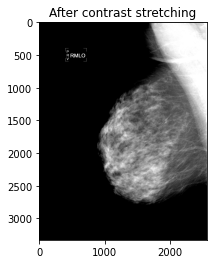

In [41]:
# Visualize the result
plt.imshow(mammo_cs, cmap="gray")
plt.title("After contrast stretching")
plt.show()

You will notice that the result at this stage is already much more readable than the raw data you started from. However, the result is still not as good as the one provided by the mammography manufacturer. In order to check for the differences, we will visualize the histogram of the mammography after inversion (before contrast stretching), after contrast stretching and the target histogram.

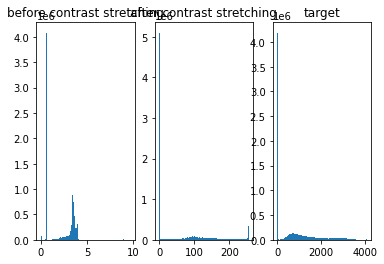

In [42]:
# Visualize and compare histograms
plt.subplot(1,3,1)
plt.hist(mammo_inv.flatten(),100)
plt.title("before contrast stretching")
plt.subplot(1,3,2)
plt.hist(mammo_cs.flatten(),100)
plt.title("after contrast stretching")
plt.subplot(1,3,3)
plt.hist(out_np.flatten(),100)
plt.title("target")
plt.show()

**Question:**
How did you define the values of p0 and pk? How much does the result change when this parameters sligthly change? Could you deduce this by having a look at the histogram?

I defined p0 and pk as values that are relatively high in the distribution of pixel values in the image. This because with the image we want to distinguish the structures that have high intensities. The window is relatively small to be able to visually distinguish between the structures with high values that are close to each other.

## Histogram equalization/matching instead of contrast stretching

The step of contrast stretching could be replaced by a histogram equalization step. In this way, we assume that the target image is known and accessible, from which we will learn some intensity value correspondance function, known as **look-up-table (LUT)**. A LUT is a table that has entries that correspond to all possible values in the input image, and each value is mapped to an output value, with the aim of mimicking the intensity distribution of the target image, the vendor mammography in our case.

Implement a function that takes as input the histogram to transform and the target histogram and return a LUT.

For more information on histogram matching, see e.g. [Wikipedia](https://en.wikipedia.org/wiki/Histogram_matching). 

**Tip**: depending on your implementation, the histogram-matched image may have an additional "color" channel (so `image.shape` is `(H, W, 1)`). This additional channel can be removed by squeezing it out: `image = image.squeeze()`.

In [43]:
def get_histogram_matching_lut(h_input, h_template):
    """Function to calculate look-up-table for 
    histogram matching from reference image
    
    Parameters
    ----------
    Input:
    h_input: histogram to transfrom
    h_template: reference histogram
    
    Returns
    -------
    LUT: look-up-table
    H_input: cumulative distribution of h_input
    H_template: cumulative distribution of h_template
    """
    
    if len(h_input) != len(h_template):
        raise ValueError("Histograms length mismatch!")
    n_bins = len(h_input)

    # YOUR CODE HERE
    H_input = np.cumsum(h_input)
    H_template = np.cumsum(h_template)
    LUT = np.interp(H_input, H_template, range(n_bins))

    # normalize LUT (such that the histogram-matched image is normalized)
    LUT = LUT / n_bins

    return LUT, H_input, H_template

In [44]:
"""DO NOT MODIFY THIS CELL"""

'DO NOT MODIFY THIS CELL'

Now that the function ````get_histogram_matching_lut()```` has been implemented, you can execute the next cell and visualize the result of the mammography image converted using histogram matching.

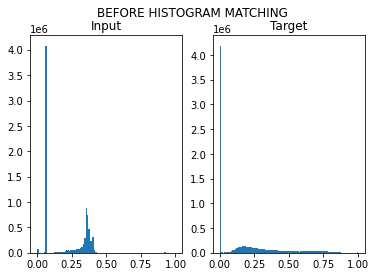

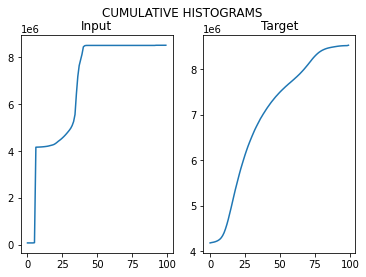

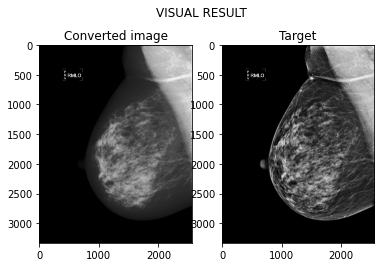

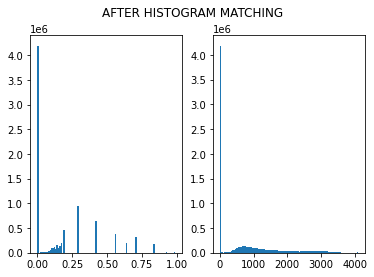

In [45]:
# Rescale images between [0,1]
out_np = out_np.astype(float)
mammo_inv_norm = (mammo_inv - mammo_inv.flatten().min())/(mammo_inv.flatten().max() - mammo_inv.flatten().min())
mammo_out_norm = (out_np - out_np.flatten().min())/(out_np.flatten().max() - out_np.flatten().min())

n_bins = 100 # Define the number of bins
hist_inv = np.histogram(mammo_inv_norm, bins=np.linspace(0., 1., n_bins+1))
hist_out = np.histogram(mammo_out_norm, bins=np.linspace(0., 1., n_bins+1))

# Compute LUT
LUT,H_input,H_template = get_histogram_matching_lut(hist_inv[0], hist_out[0])
assert(LUT        is not None),"LUT cannot be None"
assert(H_input    is not None),"H_input cannot be None"
assert(H_template is not None),"H_template cannot be None"

# Histograms before matching
plt.suptitle("BEFORE HISTOGRAM MATCHING")
plt.subplot(1, 2, 1); plt.hist(mammo_inv_norm.flatten(), 100)
plt.title("Input")
plt.subplot(1, 2, 2); plt.hist(mammo_out_norm.flatten(), 100)
plt.title("Target")
plt.show()

# Plot cumulative histogram
plt.suptitle("CUMULATIVE HISTOGRAMS")
plt.subplot(1, 2, 1); plt.plot(H_input)
plt.title("Input")
plt.subplot(1, 2, 2); plt.plot(H_template)
plt.title("Target")
plt.show()    
    
# Apply histogram matching
mammo_lut = LUT[(mammo_inv_norm * (n_bins-1)).astype(int)]
mammo_lut = mammo_lut.squeeze()

# Visual result
plt.suptitle("VISUAL RESULT")
plt.subplot(1, 2, 1); plt.imshow(mammo_lut, cmap="gray")
plt.title("Converted image")
plt.subplot(1, 2, 2); plt.imshow(out_np, cmap="gray")
plt.title("Target")
plt.show()

# histograms after matching
plt.suptitle("AFTER HISTOGRAM MATCHING")
plt.subplot(1, 2, 1)
plt.hist(mammo_lut.flatten(), 100)
plt.subplot(1, 2, 2)
plt.hist(out_np.flatten(), 100)
plt.show()

**Question:**
How did you pick the number of bins to use to do histogram matching? Does the result depend on the number of bins?



The initial number of 100 bins was too small. It only matched 100 pixel values between the template and input histogram. Although the histogram-matched image itself looked ok, 100 bins was too little because the matched histograms had relatively high peaks. Nonetheless a histogram shape similar to that of the target could already be identified. We found that a number of 100 bins matched the histograms very well, and the histogram-matched image also looks comparative of the template.


## 2. Stain normalization with histogram matching (10 points)

<img src="https://github.com/ivanslootweg/ISMI/blob/main/assignment_1/images/stain_examples.png?raw=1" alt="HE1" style="width:200px" align="right">

In the previous exercise, you implemented a histogram matching function and used it to adapt a given mammography image to a given target image. In that case, the goal was to enhance relevant information in raw mammography data and make it visible as a gray-scale image.

The same technique can be applied to the field of digital pathology, but with the aim of solving a different problem, the *variability of stain* across images.
In pathology, tissue samples are cut and stained with specific dyes in order to enhance some tissues that are relevant for the diagnosis. The most commonly used staining is called Hematoxylyn and Eosin (H&E), which is routinely applied for diagnostic purposes.
The problem with H&E is that there is a large variability of stain across laboratories, and even in the same laboratory, when staining is done in different days of the week. This is because the final result strongly depends on the type and the density of the dyes and on the time the tissue is actually exposed to the dye.

The examples on the right are images of colorectal cancer tissue samples, extracted from a publicly available dataset (https://zenodo.org/record/53169#.WJRAC_krIuU), where the appearance, mainly the colour, of the HE-stained images, is different.
Histogram matching is a technique that can help solve this problem, since we can think of adapting the distribution of colors per channel (R,G,B) by treating each channel independently.

When working with digital pathology images, it is worth noting that the image size is often big. Typical histopathology images are gigapixel images (think of Google maps to get an indea) in the order of 100,000 x 100,000 pixel. However, for the sake of simplicity, in this assignment you will only use tiles of 5000x5000 px.

### Load the slides

The code cell below will load 2 slide patches and plot them side by side.

(5000, 5000, 3)
(5000, 5000, 3)


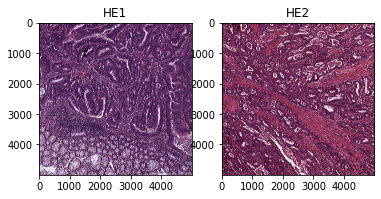

In [46]:
# load data
HE1 = sitk.GetArrayFromImage(sitk.ReadImage("./assignment_1/CRC-Prim-HE-05_APPLICATION.mha"))
HE2 = sitk.GetArrayFromImage(sitk.ReadImage("./assignment_1/CRC-Prim-HE-10_APPLICATION.mha"))

print(HE1.shape)
print(HE2.shape)

plt.subplot(1, 2, 1); plt.imshow(HE1); plt.title("HE1")
plt.subplot(1, 2, 2); plt.imshow(HE2); plt.title("HE2")
plt.show()

### Stain normalization
Implement your stain normalization function based on histogram matching based on the following definition.

In [50]:
def stain_normalization(input_img, target_img, n_bins=100):
    """ Stain normalization based on histogram matching."""
    # normalize to 0-1 range
    input_img = input_img/255.
    target_img = target_img/255.

    # YOUR CODE HERE

    # separate RGB channels of both images
    input_channels = [input_img[:, :, 0], input_img[:, :, 1], input_img[:, :, 2]]
    target_channels = [target_img[:, :, 0], target_img[:, :, 1], target_img[:, :, 2]]
    matched_channels = []

    # Reference: https://stackoverflow.com/questions/32655686/histogram-matching-of-two-images-in-python-2-x
    for count in range(len(input_channels)):
        input_type = input_channels[count].dtype
        input_shape = input_channels[count].shape
        source = input_channels[count].ravel()
        template = target_channels[count].ravel()

        # get sorted unique elements of the array along with indeces of unique values
        # to reconstruct original array and counts of each unique value
        source_values, s_indexes, source_counts = np.unique(source, return_inverse=True,
                                                return_counts=True)
        target_values, target_counts = np.unique(template, return_counts=True)

        # cumulutative sum of the values of the flattened array
        s_quantiles = np.cumsum(source_counts).astype(np.float64)
        s_quantiles /= s_quantiles[-1]
        t_quantiles = np.cumsum(target_counts).astype(np.float64)
        t_quantiles /= t_quantiles[-1]

        # interpolate linearly to find values in target_values that 
        # correspond most closely to the source quantiles
        interp_t_values = np.interp(s_quantiles, t_quantiles, target_values)
        interp_t_values = interp_t_values.astype(input_type) # ensure type
        # reshape to the original 5000x5000 image
        matched_channels.append(interp_t_values[s_indexes].reshape(input_shape))

    # stack three channels together creating 3D array out of 3x2D arrays of the channels
    stain_norm_img = np.dstack((matched_channels[0], matched_channels[1], matched_channels[2]))


    # convert back to uint8 range
    stain_norm_img = (255.0*stain_norm_img).astype(np.uint8)
    return stain_norm_img

In [51]:
"""DO NOT MODIFY THIS CELL"""

'DO NOT MODIFY THIS CELL'

Now you can use the implemented function to do stain normalization and check the result.

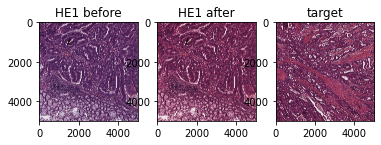

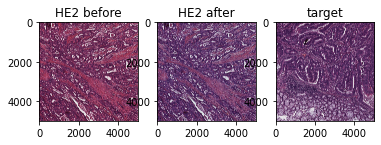

In [52]:
# Transform HE1 to match HE2
HE1_norm = stain_normalization(HE1, HE2);
assert(HE1_norm is not None),"HE1_norm cannot be None"

plt.subplot(1,3,1)
plt.imshow(HE1); plt.title("HE1 before")
plt.subplot(1,3,2)
plt.imshow(HE1_norm); plt.title("HE1 after")
plt.subplot(1,3,3)
plt.imshow(HE2); plt.title("target")
plt.show()

# Transform HE2 to match HE1
HE2_norm = stain_normalization(HE2, HE1);
plt.subplot(1,3,1); plt.imshow(HE2)
plt.title("HE2 before")
plt.subplot(1,3,2); plt.imshow(HE2_norm)
plt.title("HE2 after")
plt.subplot(1,3,3); plt.imshow(HE1)
plt.title("target")
plt.show()

## 3. Trachea detection in chest CT (35 points)

<img src="https://github.com/ivanslootweg/ISMI/blob/main/assignment_1/images/tracheaAxial.png?raw=1"   align="right">

The last part of this assignment is about automatic detection of the trachea in slices of a chest CT scan.
The detection of the trachea is often used as initialization of airway segmentation algorithms, where the position of the trachea is used as a seed point to grow segmentation methods.
For this purpose, you are going to develop a **blob detector** and process all slides of a given scan.
The idea is to implement an algorithm that reads an entire CT scan and returns the coordinates (x,y,z) of a point inside the trachea, which can be used as a reliable seed point for future analysis.
See the slice besides that shows where to find the trachea. For more images, visit:
- https://w-radiology.com/chest_ct/
- https://w-radiology.com/chest_ct-parenchyma/ check it in Coronal view

### Loading DICOM
To develop our algorithm, we will use data from the publicly available dataset LIDC-IDRI (https://wiki.cancerimagingarchive.net/display/Public/LIDC-IDRI).
The database contains 1018 scans, but we will only use the first scan for this assignment, which you can find in the data folder.
The format of the chest CT file is DICOM, and for this we will need a dicom library in python. In this assignment we use `SimpleITK`, but there are alternatives (e.g. `pydicom`).
The following code can be used to read all files in a given folder. 

In [53]:
# Load the first scan from LIDC-IDRI
scan_path = "./assignment_1/LIDC-IDRI/LIDC-IDRI-0001/1.3.6.1.4.1.14519.5.2.1.6279.6001.298806137288633453246975630178/1.3.6.1.4.1.14519.5.2.1.6279.6001.179049373636438705059720603192"

# Read all dicom files in the folder
reader = sitk.ImageSeriesReader()
dicom_slice_paths = reader.GetGDCMSeriesFileNames(scan_path)
reader.SetFileNames(dicom_slice_paths)
image = reader.Execute()

# Convert the slice to a numpy array
ct_slice_numpy = sitk.GetArrayFromImage(image)
dims = image.GetSize()

# Print scan information
print(f"Found {len(dicom_slice_paths)} dicom files, resulting in an image of dimension {dims}")

Found 133 dicom files, resulting in an image of dimension (512, 512, 133)


For convenience, we convert the image to a numpy array.

In [54]:
scan = sitk.GetArrayFromImage(image)
print(scan.shape)

(133, 512, 512)


### Seed point detection

<img src="https://github.com/ivanslootweg/ISMI/blob/main/assignment_1/images/gaussian.gif?raw=1" align="right" width="250">


A blob detector is based on a Gaussian function, which has to be applied at a given scale (i.e., to find small or large blobs). This scale is problem-specific: in our case we need to find blobs with a size comparable to the trachea.
As a first step, define a function to make Gaussian kernels in 2D, given a value for **sigma in millimiters**, given by:

\begin{equation}
G(x,y) = \frac{1}{2\pi\sigma^2}\exp^{-(x^2+y^2)/(2\sigma^2)}
\end{equation}

Do not forget to take into account for the voxel size in x and y direction of the CT scan when designing the filters.
This information can be found in the header of the dicom file.

Your kernel should have a kernel size of $3\sigma$ (meaning both $x$ and $y$ range from $-3 \sigma$ to $+3 \sigma$). Round the number of pixels in the kernel up to ensure $-3 \sigma$ to $+3 \sigma$ "fits".

In [55]:
import math

def gaussian_2d(sigma_mm, voxel_size):
    """
    Parameters
    ----------
    sigma_mm: sigma in mm
    voxel_size: the size of a voxel in mm
    
    Returns
    -------
    kernel: kernel
    x : matrix of x coordinates of the filter
    y : matrix of y coordinates of the filter
    """
    # YOUR CODE HERE

    x_matrix = np.arange(-3*sigma_mm+0.5*voxel_size[0],3*sigma_mm-0.4*voxel_size[0], voxel_size[0])
    y_matrix = np.arange(-3*sigma_mm+0.5*voxel_size[1],3*sigma_mm-0.4*voxel_size[1], voxel_size[1])

    x_size = len(x_matrix)
    y_size = len(y_matrix)

    x_matrix = np.repeat([x_matrix], y_size, axis=0)
    y_matrix = np.repeat([y_matrix], x_size, axis=0).T

    kernel = np.empty((x_size, y_size))

    for x_index in range(x_size):
      for y_index in range(y_size):
        x = x_matrix[0][x_index]
        y = y_matrix[y_index][0]
        kernel[x_index][y_index] = (1 / (2 * math.pi * sigma_mm**2)) * math.exp(-(x**2+y**2)/(2*sigma_mm**2))

    return kernel, x_matrix, y_matrix 

gaussian_2d(2, [2,1])

(array([[3.98486740e-05, 1.39085539e-04, 3.78073693e-04, 8.00382013e-04,
         1.31960685e-03, 1.69440874e-03, 1.69440874e-03, 1.31960685e-03,
         8.00382013e-04, 3.78073693e-04, 1.39085539e-04, 3.98486740e-05],
        [2.94444088e-04, 1.02771085e-03, 2.79360772e-03, 5.91406760e-03,
         9.75064904e-03, 1.25200812e-02, 1.25200812e-02, 9.75064904e-03,
         5.91406760e-03, 2.79360772e-03, 1.02771085e-03, 2.94444088e-04],
        [8.00382013e-04, 2.79360772e-03, 7.59381311e-03, 1.60761025e-02,
         2.65050121e-02, 3.40331092e-02, 3.40331092e-02, 2.65050121e-02,
         1.60761025e-02, 7.59381311e-03, 2.79360772e-03, 8.00382013e-04],
        [8.00382013e-04, 2.79360772e-03, 7.59381311e-03, 1.60761025e-02,
         2.65050121e-02, 3.40331092e-02, 3.40331092e-02, 2.65050121e-02,
         1.60761025e-02, 7.59381311e-03, 2.79360772e-03, 8.00382013e-04],
        [2.94444088e-04, 1.02771085e-03, 2.79360772e-03, 5.91406760e-03,
         9.75064904e-03, 1.25200812e-02, 1.2520

In [ ]:
"""DO NOT MODIFY THIS CELL"""

#### Laplacian of Gaussian (LoG) <img src="https://github.com/ivanslootweg/ISMI/blob/main/assignment_1/images/LoG.png?raw=1" width="250" align="right">
Now define a function to make the Laplacian of Gaussian defined by:

\begin{equation}
\nabla^2G(x,y) = \frac{\partial^2G(x,y)}{\partial x^2} + \frac{\partial^2G(x,y)}{\partial y^2}
\end{equation}

This function should work for any (2D) input array `g`, such as the `kernel` made above. As such, use numerical derivatives (e.g., `np.gradient`) rather than analytically deriving the LoG. If you want, you can multiply the LoG by -1, to match the figure on the right.

In [56]:
def laplacian_of_gaussian(g):
    """Compute the Laplacian of Gaussian
    
    Parameters
    ----------
    g : 2d numpy array

    Returns
    -------
    LoG : 2d numpy array
    gxx : 2d numpy array
        Second partial derivative of g to x
    gyy : 2d numpy array
        Second partial derivative of g to y
    """
    # YOUR CODE HERE

    gxx, gyy = np.gradient(g)

    gxx = np.gradient(gxx)[0]
    gyy = np.gradient(gyy)[1]

    LoG = (gxx + gyy) * -1

    return LoG,gxx,gyy

laplacian_of_gaussian(gaussian_2d(10,[0.7,0.7])[0])

(array([[-1.07591250e-08, -1.50909525e-08, -2.05375287e-08, ...,
         -2.30419118e-08, -1.70211091e-08, -1.21989243e-08],
        [-1.50909525e-08, -2.08374662e-08, -2.80361902e-08, ...,
         -3.15349644e-08, -2.35636359e-08, -1.71566259e-08],
        [-2.05375287e-08, -2.80361902e-08, -3.74023754e-08, ...,
         -4.21503125e-08, -3.17647439e-08, -2.33938669e-08],
        ...,
        [-2.30419118e-08, -3.15349644e-08, -4.21503125e-08, ...,
         -4.74806023e-08, -3.57135959e-08, -2.62353414e-08],
        [-1.70211091e-08, -2.35636359e-08, -3.17647439e-08, ...,
         -3.57135959e-08, -2.66349864e-08, -1.93424292e-08],
        [-1.21989243e-08, -1.71566259e-08, -2.33938669e-08, ...,
         -2.62353414e-08, -1.93424292e-08, -1.38249238e-08]]),
 array([[5.37956252e-09, 6.60420823e-09, 8.06801158e-09, ...,
         9.28042233e-09, 7.62328253e-09, 6.23143757e-09],
        [8.48674424e-09, 1.04187331e-08, 1.27280147e-08, ...,
         1.46407018e-08, 1.20264146e-08, 9.8306

In [ ]:
"""DO NOT MODIFY THIS CELL"""

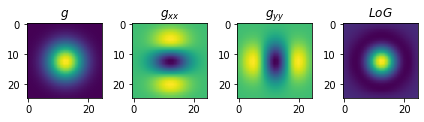

In [59]:
# Compute LoG
g,x,y = gaussian_2d(3.0, [0.7, 0.7])
assert(g is not None),"g cannot be None"
assert(x is not None),"x cannot be None"
assert(y is not None),"y cannot be None"

LoG,gxx,gyy = laplacian_of_gaussian(g)
assert(LoG is not None),"LoG cannot be None"
assert(gxx is not None),"gxx cannot be None"
assert(gyy is not None),"gyy cannot be None"

#visualize the filters
plt.subplot(1,4,1)
plt.imshow(g)
plt.title(r"$g$")
plt.subplot(1,4,2)
plt.imshow(gxx)
plt.title(r"$g_{xx}$")
plt.subplot(1,4,3)
plt.imshow(gyy)
plt.title(r"$g_{yy}$")
plt.subplot(1,4,4)
plt.imshow(LoG)
plt.title(r"$LoG$")
plt.tight_layout()
plt.show()

You can also visualize your Gaussian filter using a surface-like visualization.

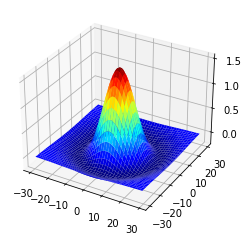

In [60]:
# Filter surface visualization
g,x,y = gaussian_2d(10.0, [0.7, 0.7])
LoG,gxx,gyy = laplacian_of_gaussian(g)
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
surf = ax.plot_surface(x, y, LoG, antialiased=True, cmap=cm.jet, linewidth=0)
plt.show()

We also provide a function that extracts the area that belongs to the thorax for each slice. It is based on some morphology operations that we have not seen yet. No worries if you don't understand it at the moment! You can use it if you think it can be useful in your implementation.

In [61]:
# Function to get the area of the thorax
def get_body(ct_slice_numpy):
    thorax = (ct_slice_numpy > -524)
    thorax = binary_fill_holes(thorax)
    label, num_label = scipy.ndimage.label(thorax)
    size = np.bincount(label.ravel())
    biggest_label = size[1:].argmax() + 1
    thorax = (label == biggest_label)
    return thorax  

Now apply LoG to all slices in the image. We apply the filter by using the convolution operation. When the filter size becomes big, working in the frequency domain is much faster. For this purpose you can use the fast fourier transform. Think of the size of the filter, whether one filter size is enough or whether multiple sizes have to be used. Tune the scale(s) based on realistic assumptions.

In the end, capture your algorithm for finding the (x, y, z) coordinate of a point inside the trachea in the function template shown below, such that the code cell will plot your prediction.

(133, 571, 571)
37959128
(116, 242, 190)


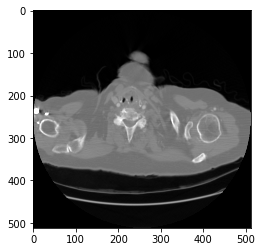

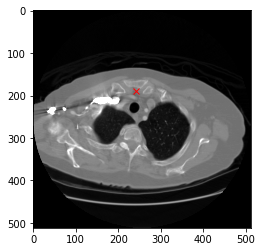

In [77]:
from numpy.lib.index_tricks import index_exp
from scipy.signal.signaltools import fftconvolve
# You can use this code cell to experiment
# Put your final algorithm inside this function and verify that it works using the visualization

def find_seed_point(scan, verbose=0):
    """Find a point inside the trachea

    Parameters
    ----------
    scan: 3D numpy array
    verbose: (optional) set to 1 to show information for debugging

    Returns
    -------
    seed_point: 3-tuple, (x,y,z)
    """
    seed_point = (0, 0, 0)
    # YOUR CODE HERE

    g,x,y = gaussian_2d(1, [0.1, 0.1])
    LoG,gxx,gyy = laplacian_of_gaussian(g)

    conveluted_image = fftconvolve(scan[0], LoG)

    conveluted_scan = np.zeros((scan.shape[0], conveluted_image.shape[0], conveluted_image.shape[1]))

    for i in range(len(scan)):

      image = scan[i]

      plt.imshow(image, vmin=-1024.0, vmax=1024.0, cmap="gray")

      conveluted_image = fftconvolve(image, LoG)
      conveluted_scan[i] += conveluted_image

      if verbose:
        plt.figure()
        plt.imshow(conveluted_image, vmin=-1024.0, vmax=1024.0, cmap="gray")
        plt.show()


    print(conveluted_scan.shape)
    print(np.argmax(conveluted_scan))
    print(np.unravel_index(np.argmax(conveluted_scan), conveluted_scan.shape))

    z,x,y = np.unravel_index(np.argmax(conveluted_scan), conveluted_scan.shape)

    seed_point = (x,y,z)

    return seed_point

seed_point = find_seed_point(scan,0)
plt.figure()
plt.imshow(scan[seed_point[2], :, :], vmin=-1024.0, vmax=1024.0, cmap="gray")
plt.plot(seed_point[0], seed_point[1], "rx")
plt.show()

**Question:**
What are the criteria that you assumed in order to pick the value(s) of sigma?

It was hard to make a based decision for our choice of sigma since we couldnt check whether different values had better or worse results.

**Question:**
Is the seed-point that you found unique, or could you find more than one? In that case, how did you choose the one you used?

The argmax function only returns one value as there most of the times only is one maximum value the scan.